Cluster Centers (Release Year, Duration minutes):
  Cluster 0: Year=2017.6, Duration=93.6
  Cluster 1: Year=1993.7, Duration=119.0
  Cluster 2: Year=2011.4, Duration=104.7


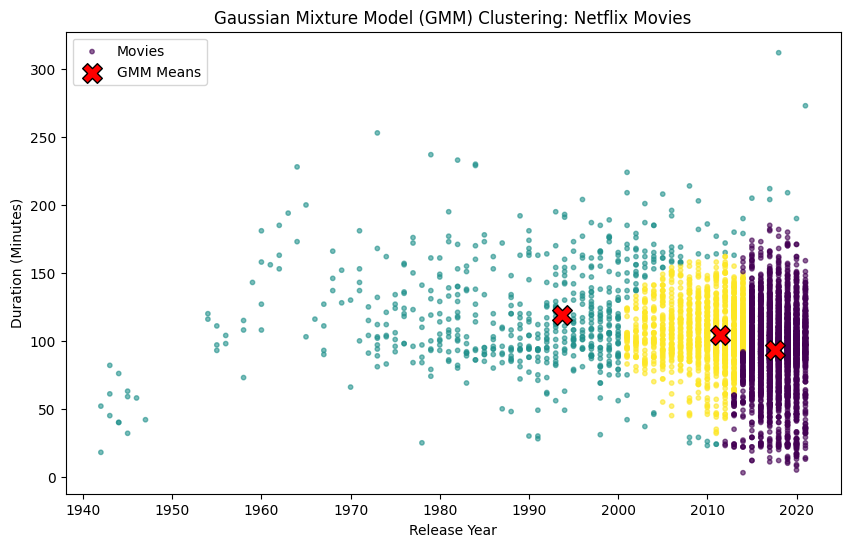

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# ---------- 1. Data Preparation ----------

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/netflix_data.csv')

# Filter for Movies only
df_movies = df[df['type'] == 'Movie'].copy()

# Extract numeric duration: "90 min" -> 90
df_movies['duration_min'] = (
    df_movies['duration']
    .str.replace(' min', '', regex=False)
    .astype(float)
)

# Drop rows with missing year or duration
df_movies = df_movies.dropna(subset=['duration_min', 'release_year'])

# Features: Release Year & Duration
features = df_movies[['release_year', 'duration_min']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ---------- 2. Gaussian Mixture Model (GMM) ----------

n_components = 3   # number of clusters

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',   # 'full', 'tied', 'diag', 'spherical'
    random_state=42
)

gmm.fit(X_scaled)

# Soft cluster probabilities (responsibilities)
probs = gmm.predict_proba(X_scaled)      # shape: (n_samples, n_components)

# Hard labels (most likely cluster)
labels = gmm.predict(X_scaled)

# Cluster centers in scaled space -> back to original units
centroids_scaled = gmm.means_
centroids_original = scaler.inverse_transform(centroids_scaled)

print("Cluster Centers (Release Year, Duration minutes):")
for i, c in enumerate(centroids_original):
    print(f"  Cluster {i}: Year={c[0]:.1f}, Duration={c[1]:.1f}")

# ---------- 3. Attach results to DataFrame (optional) ----------

for k in range(n_components):
    df_movies[f'prob_cluster_{k}'] = probs[:, k]
df_movies['assigned_cluster'] = labels

# Save if you want
df_movies.to_csv('netflix_movies_gmm_results.csv', index=False)

# ---------- 4. Visualization ----------

plt.figure(figsize=(10, 6))

# Scatter movies colored by hard cluster
plt.scatter(
    features[:, 0],
    features[:, 1],
    c=labels,
    cmap='viridis',
    s=10,
    alpha=0.6,
    label='Movies'
)

# Plot GMM means
plt.scatter(
    centroids_original[:, 0],
    centroids_original[:, 1],
    c='red',
    s=200,
    marker='X',
    edgecolors='black',
    label='GMM Means'
)

plt.title('Gaussian Mixture Model (GMM) Clustering: Netflix Movies')
plt.xlabel('Release Year')
plt.ylabel('Duration (Minutes)')
plt.legend()
plt.show()
